pygame 2.1.2 (SDL 2.0.16, Python 3.10.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pygame

STR_LENGTH = 10
N_AGENTS = 10
O_m = list()
A_m = list()
I_nm = list()
            
class Agent(object):
    def __init__(self, x=np.random.randn(), y=np.random.randn(), dx=0, dy=0, phi=0):
        self.x = x
        self.y = y
        self.dx = dx
        self.dy = dy
        self.message = np.random.choice(STR_LENGTH, [0, 1])
        self.phi = phi #função de atualização de estado
        self.state = np.array([x, y, dx, dy, self.message, self.phi])

    def update(self, env):
        self.state = self.phi(env)
        self.x = self.state[0]
        self.y = self.state[1]
        self.dx = self.state[2]
        self.dy = self.state[3]
        self.message = self.state[4]
        self.phi = self.state[5]
    
    def phi(self, env):
        
        mb = env.mb
        #process messages

        #determine move

        #determine message

        #update state
        self.x = self.x + self.dx
        self.y = self.y + self.dy

        #possibly update phi
        self.phi = self.phi


class Environment(object):
    def __init__(self, num_agents = 10, o_m = [], a_m = [], i_nm = []):

        self.agents = {f"{i}": Agent() for i in range(num_agents)}
        self.message_board = MessageBoard(agents=self.agents)
        self.agents_positions = np.array([np.array([self.agents[f"i"].x, self.agents[f"i"].y]) for i in range(num_agents)])
        self.board = np.zeros((num_agents*3, num_agents*3))

    def update_board(self):
        self.message_board.update()

class MessageBoard(object):
    def __init__(self, agents, messages: dict = None):
        self.agents=agents
        self.messages = messages
        if self.messages is not None:
            self.messages = {}
    def update(self):
        for (k, v) in self.agents.items():
            self.messages[k] = v.message
    def __str__(self):
        for i in range(len(self.messages)):
            print(self.messages[i])

In [ ]:
mb = MessageBoard()

In [96]:
# DIM = 3
# CARRIERS = 9
NUM_AGENTS = 64
NUM_STATES = 3
NUM_PERCEPTIONS = 3
NUM_ACTIONS = 512
NUM_THINGS = 3
# Model testing
MULT = 2
RES = 512

def rotate(x, angle): 
    ca = t.cos(angle)
    sa = t.sin(angle)
    
    return t.cat([ca*x[:,:,:,0:1]+sa*x[:,:,:,1:2], -sa*x[:,:,:,0:1]+ca*x[:,:,:,1:2]], 3)

def sigmoid(x):
    return 1/(1+np.exp(-0.25 * x))

# dim 3 carries the x,y variation
def mirror(p):
    p = RES-1-p
    w1 = t.le(p,0).long()
    p = (1-w1)*p + w1*(-p)

    p = RES-1-p
    w1 = t.le(p,0).long()
    p = (1-w1)*p + w1*(-p)
    
    return p

class RadConv(nn.Module):
    def __init__(self, NI, radius):
        super().__init__()
        self.conv = nn.Conv2d(NI, NI, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        
        avg_weight = t.zeros_like(self.conv.weight.data)
        
        for theta in np.arange(0,2*np.pi,np.pi/256.0):
            avg_weight += rotate(self.conv.weight.data.detach().clone(), 180*theta/np.pi)/128.0
        
        avg_weight /= avg_weight.sum(3).sum(2).unsqueeze(2).unsqueeze(3)
        
        self.conv.weight.data = avg_weight
        for i in range(NI):
            for j in range(i):
                self.conv.weight.data[i,j] = 0
                self.conv.weight.data[j,i] = 0
    
    def forward(self, x):
        return self.conv(x)

In [97]:
t.tensor(np.arange(0,2*np.pi,np.pi/256.0)).cuda().shape

torch.Size([512])

In [123]:
directions = t.tensor([theta for theta in np.arange(0,2*np.pi,np.pi/256.0)]).cuda().view(NUM_ACTIONS, 1); print(directions.shape)
num_directions = directions.shape[0]; print(num_directions)
speeds = t.tensor([speed for speed in t.rand(num_directions)]).cuda().view(NUM_ACTIONS, 1); print(speeds.shape)
actions = t.cat([speeds, directions], 1); print(actions.shape)

torch.Size([512, 1])
512
torch.Size([512, 1])
torch.Size([512, 2])


In [124]:
positions = t.rand(NUM_AGENTS, 2).cuda(); print(positions.shape)

torch.Size([64, 2])


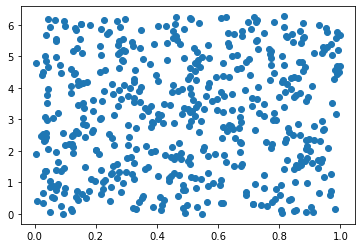

In [125]:
plt.scatter(actions.cpu().numpy()[:, 0], actions.cpu().numpy()[:, 1])

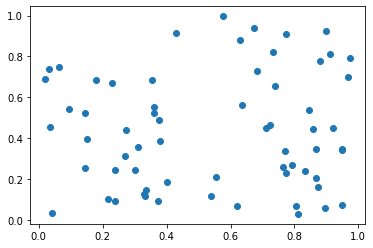

In [126]:
plt.scatter(positions.cpu().numpy()[:, 0], positions.cpu().numpy()[:, 1])

In [144]:

radius = 5

class Agents(nn.Module):
    def __init__(self, positions, actions, states = t.rand(NUM_AGENTS, NUM_STATES), perceptions = t.rand(NUM_AGENTS, NUM_PERCEPTIONS), things = t.rand(NUM_THINGS)):
        super(Agents, self).__init__()
        self.position = positions
        self.actions = actions
        self.state = states
        self.perceptions = perceptions
        # self.perceptual_apparatus = RadConv(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES*NUM_THINGS*2.0, 9) #things in the environment; other agents states, their perceptions etc; NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS
        self.conv = nn.Conv2d(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES*NUM_THINGS*2, NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        self.fc1 = nn.Linear(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES)
        self.fc2 = nn.Linear(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_AGENTS*NUM_PERCEPTIONS)
        self.fc3 = nn.Linear(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_AGENTS*NUM_STATES)
        self.fc4 = nn.Linear(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_AGENTS*NUM_ACTIONS)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        self.perceptions = F.softmin(self.fc2(x).view(NUM_AGENTS, NUM_PERCEPTIONS), dim=1)
        self.states = F.softmax(self.fc3(x).view(NUM_AGENTS, NUM_STATES), dim=1)
        self.actions = F.softmax(self.fc4(x).view(NUM_AGENTS, NUM_ACTIONS), dim=1)
        return t.cat([self.perceptions, self.states, self.actions], 1)

In [145]:
agents = Agents(positions, actions).cuda()

In [149]:
agents.state.shape, agents.perceptions.shape, agents.actions.shape

(torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([512, 2]))

In [121]:
class Environment(nn.Module):
    def __init__(self, spatial_contents, env_state, agents):
        super(Environment, self).__init__()
        self.spatial_contents = spatial_contents
        self.state = env_state
        self.agents = agents
        # self.fc1 = nn.Linear(state, 128)
        # self.fc2 = nn.Linear(128, 128)
        # self.fc3 = nn.Linear(128, contents)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        return x

In [122]:

class Environment(object):
    def __init__(self, agents = None, actions = None):
        self.state = np.zeros(STR_LENGHT)
        self.state[0] = 1
        self.state[STR_LENGHT - 1] = 1
        self.action_space = [0, 1]
        self.action_space_size = len(self.action_space)
        self.action_space_size = len(self.action_space)
        self.reset()
        self.render()

    def reset(self):
        self.state = np.zeros(STR_LENGHT)
        self.state[0] = 1
        self.state[STR_LENGHT - 1] = 1
        self.render()

    def step(self, action):
        if action == 0:
            self.state[0] = 0
            self.state[1] = 1
        elif action == 1:
            self.state[STR_LENGHT - 1] = 0
            self.state[STR_LENGHT - 2] = 1
        self.render()
        reward = self.get_reward()
        done = self.is_done()
        return self.state, reward, done, {}

    def render(self):
        print(self.state)

    def is_done(self):
        if (self.state[0] == 1 and self.state[STR_LENGHT - 1] == 1):
            return True
        else:
            return False

    def get_reward(self):
        if (self.state[0] == 1 and self.state[STR_LENGHT - 1] == 1):
            return 1
        else:
            return 0

TypeError: empty(): argument 'size' must be tuple of ints, but found element of type float at pos 2

In [ ]:
pygame.init()
screen = pygame.display.set_mode((MULT*RES,MULT*RES), 0, 24)
